In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.container { font-size:16px !important; }</style>"))

import numpy as np 
import matplotlib.pyplot as plt 

from matplotlib import rcParams
#rcParams['font.family'] = 'sans'
#rcParams['font.sans-serif'] = ['Tahoma']
rcParams['font.size'] = 22
#rcParams['text.usetex'] = True
import matplotlib.pyplot as plt 

In [7]:
# These are our functions, that we made, I will explain them as we use them.

from rtfunctions import one_full_fs, sc_2nd_order, calc_lambda_full, calc_lambda_monoc

In [9]:
# We will define a discrete grid for our spacial coordinate, that is logtau 
# By this I mean logtau in the continuum:

ND = 91
logtau = np.linspace(-7,2,ND)
tau = 10.0**logtau

# Planck Function, so the atmosphere is isothermal:
B = np.zeros(ND)
B[:] = 1.0
# Photon destruction probability, smaller this is, more NLTE we are.
eps = np.zeros(ND)
eps[:] = 1E-4
# The ratio between line and continuum opacity
line_ratio = 1E3



(51,)


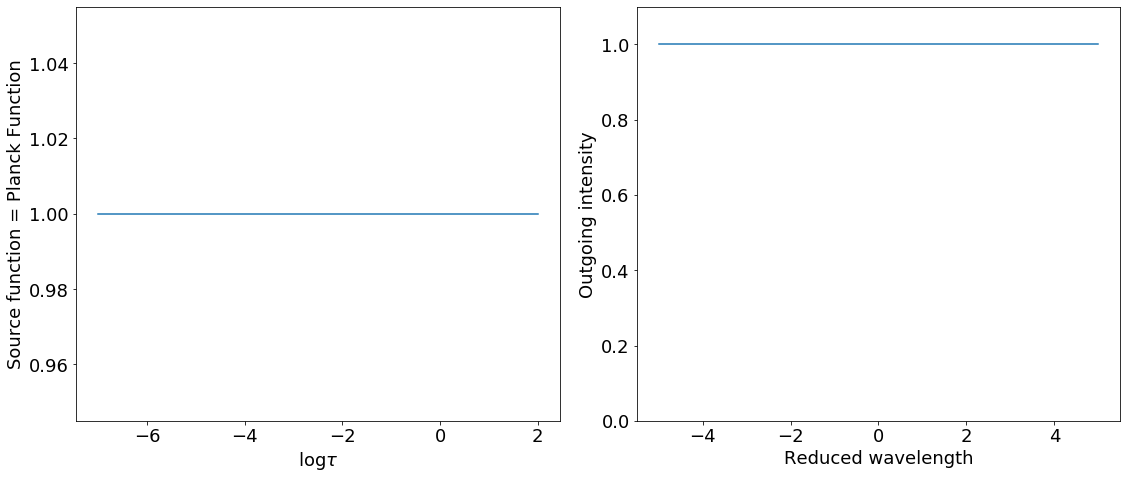

In [13]:
# This was an isothermal atmosphere. 

# Now we need to specify the wavelength grid we are going to work in:
# Wavelength grid, in Doppler width units.
# Profile is constant with depth, for simplicity
NL = 51
x = np.linspace(-5,5,NL)
profile = 1./np.sqrt(np.pi) * np.exp(-(x**2.0))


# We can now play a little bit and see what comes out of this atmosphere:
# Do perform one formal solution you can do something like:

I_out = one_full_fs(tau*line_ratio,B,1.0,profile,B[-1])
print (I.shape)

plt.figure(figsize=[16,7])
plt.subplot(121)
plt.plot(logtau, B)
plt.xlabel("$\\log\\tau$")
plt.ylabel("Source function = Planck Function")
plt.subplot(122)
plt.plot(x, I)
plt.xlabel("Reduced wavelength")
plt.ylabel("Outgoing intensity")
plt.ylim([0,1.1])
plt.tight_layout()



Obviously there is no spectral line because the temperature is constant! To study that better, let's calculate all the intensities at all the points.

In [16]:
I = np.zeros([ND,NL])
for l in range(0,NL):
    I[:,l] = sc_2nd_order(tau*profile[l]*line_ratio,B,1.0,B[-1])[0]
I.shape

(91, 51)

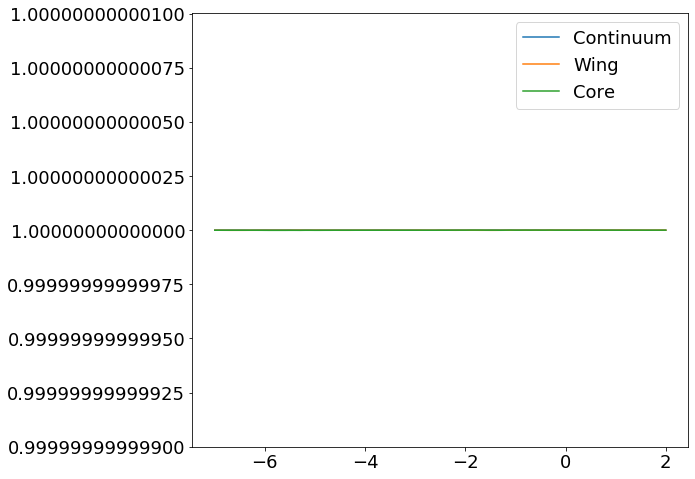

In [18]:
#Now I will plot run of the intensity with depth for few wavelenghts
plt.figure(figsize=[10,7])
plt.plot(logtau,I[:,0],label='Continuum')
plt.plot(logtau,I[:,15],label='Wing')
plt.plot(logtau,I[:,25],label='Core')
plt.legend()
plt.xlabel("$\\log\\tau$")
plt.ylabel("Intensity")
plt.ticklabel_format(useOffset=False)
plt.tight_layout()

However, let's see what happens when we calculate the intensity that comes IN the atmosphere (it will be needed in a sec). Note different direction and the boundary value

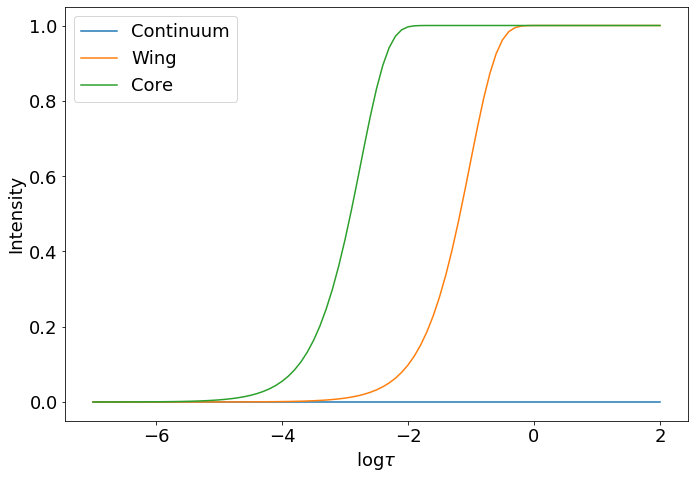

In [19]:
I = np.zeros([ND,NL])
for l in range(0,NL):
    I[:,l] = sc_2nd_order(tau*profile[l]*line_ratio,B,-1.0,0.0)[0]
plt.figure(figsize=[10,7])
plt.plot(logtau,I[:,0],label='Continuum')
plt.plot(logtau,I[:,15],label='Wing')
plt.plot(logtau,I[:,25],label='Core')
plt.legend()
plt.xlabel("$\\log\\tau$")
plt.ylabel("Intensity")
plt.ticklabel_format(useOffset=False)
plt.tight_layout()

In [ ]:
# Wavelength integration weights
prof_norm = np.sum(profile)
wx = np.zeros(NL)
wx[0] = (x[1] - x[0]) * 0.5
wx[-1] = (x[-1] - x[-2]) * 0.5
wx[1:-1] = (x[2:NL] - x[0:-2]) * 0.5
norm =  (np.sum(profile*wx))
wx/= norm

# Angle integration:
mu=([1./np.sqrt(3.0)])
wmu=[1.0]
mu=np.cos([0.4793425352,1.0471975512,1.4578547042])
wmu=[.2777777778,0.4444444444,0.2777777778]
NM = mu.shape[0]
mu = np.asarray(mu)
wmu = np.asarray(wmu)

#Boundary conditions and starting value for the source function
I_boundary_lower = B[-1];
I_boundary_upper = 0.0;
S = np.copy(B)

# Iteration part
for iter in range(0,200):
	
	# Initialize the scattering integral and local lambda operator
	J = np.zeros(ND)
	L = np.zeros(ND)

	# For each direction and wavelength, calculate the specific monochromatic intensity
	# and add contributions to the mean intensity and the local operator
	for m in range(0,NM):
		for l in range(0,NL):

			#outward
			ILambda = sc_2nd_order(tau*profile[l]*line_ratio,S,mu[m],B[-1])

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5

			#inward
			ILambda = sc_2nd_order(tau*profile[l]*line_ratio,S,-mu[m],0)

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5
	
	# Correct the source function using local ALI approach:		
	dS = (eps * B + (1.-eps) * J - S) / (1.-(1.-eps)*L)

	# Check for change
	max_change  = np.max(np.abs(dS / S))
	print (max_change)

	# Correct the source function
	S += dS
	if (max_change<1E-4):
		break;

# Calculate the full lambda operator 
LL = calc_lambda_full(tau*line_ratio,mu,wmu,profile,wx)

# Response function of the source function to the temperature:
dS_dB = np.linalg.inv(np.eye(ND)-(1.-eps)*LL)@ (eps*np.eye(ND))

# Then the emergent intensity is:
# We use more refined profile to get a nicer-looking line
x_detailed = np.linspace(-6,6,121)
detailed_profile = 1./np.sqrt(np.pi) * np.exp(-x_detailed**2.0)

# Spectra is result of one formal solution in direction mu = 1
spectra = one_full_fs(tau*line_ratio,S,1.0,detailed_profile,B[-1])

# Response function of the intensity we will calculate by perturbing the source function
# at each depth by the response we just calculated and then subtracting the original one
rf = np.zeros((ND,detailed_profile.shape[0]))
for d in range(0,ND):
	rf[d] = one_full_fs(tau*line_ratio,S+dS_dB[:,d]*1E-3,1.0,detailed_profile,B[-1])-spectra

CF = np.zeros((ND,detailed_profile.shape[0]))

for l in range(0,detailed_profile.shape[0]):
	CF[:,l] = S * np.exp(-tau*line_ratio*detailed_profile[l] * tau*line_ratio*detailed_profile[l])

#plot the results.
plt.figure(figsize=[14,5])
plt.clf()
plt.cla()
plt.subplot(121)
plt.pcolormesh(x_detailed,np.log10(tau),rf/spectra)
plt.xlabel("Reduced wavelength")
plt.ylabel("$\\mathcal{R}(\\tau,\lambda)/I_\lambda$")
plt.title("Response function")
plt.subplot(122)
plt.pcolormesh(x_detailed,np.log10(tau),CF/spectra)
plt.xlabel("Reduced wavelength")
plt.ylabel("$\\mathcal{C}(\\tau,\lambda)/I_\lambda$")
plt.title("Contribution function")
plt.tight_layout()
plt.savefig("2LVL_NLTE_RF_vs_CF.png",fmt='png',bbox_inches='tight')

#plot more results 
plt.clf()
plt.cla()
plt.subplot(121)
plt.plot(np.log10(tau),np.log10(S),label='Source function')
plt.plot(np.log10(tau),np.log10(B),label='Planck function')
plt.legend()
plt.xlabel("$\\log\\tau_c$")
plt.subplot(122)
plt.plot(x_detailed,spectra)
plt.xlabel("Reduced wavelength")
plt.ylabel("Intensity")
plt.tight_layout()
plt.savefig("2LVL_NLTE.png",fmt='png',bbox_inches='tight')